In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold


from src.data.data_fetcher import get_all_features, get_raw_data
from src.features.feature_engineering import prepare_data
from src.features.preprocess_data import get_preprocessed_test_data, fetch_preprocessed_data, fetch_preprocessed_uniform_data
pd.set_option('display.max_columns', 200)


from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')


%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\gunna\Documents\Maskinlæring\Prosjekt\power-predictor\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = get_raw_data()



X_train_obs_combined, X_val_obs_combined, y_train_obs_combined, y_val_obs_combined, X_train_est_combined, X_val_est_combined, y_train_est_combined, y_val_est_combined = fetch_preprocessed_data()
X_test_estimated_a_processed, X_test_estimated_b_processed, X_test_estimated_c_processed = get_preprocessed_test_data()



x_whole = pd.concat([X_train_obs_combined, X_val_obs_combined])
y_whole = pd.concat([y_train_obs_combined, y_val_obs_combined])
x_whole.reset_index(drop=True, inplace=True)
y_whole.reset_index(drop=True, inplace=True)



x_whole.head()


# y_train_obs_combined.shape


,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,sun_azimuth:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,location_a,location_b,location_c,sin_day_of_year,cos_day_of_year,sin_hour,cos_hour,sun_product,modified_solar_elevation,effective_radiation,residual_radiation,cloud_ratio,cloud_cover_over_30%,sun_addition,is_freezing,is_snow,is_rain
0,4.675,1.23925,0.000000e+00,0.000000,2067.925049,0.0,272.924988,0.000000,0.000000,0.000000,0.000000,91.949997,0.0,1.0,988.150024,0.0,0.0,975.549988,981.574951,0.0,0.0,65.949997,987.650024,252.160492,0.0,279.774994,98.974998,45661.750000,3.800,1.100,3.625,0.0,1,0,0,-0.638384,0.769718,-0.866025,-0.500000,0.000000,0.000000,0.000000,0.000000,0.929022,1,0.000000,0,0,0
1,4.400,1.23625,4.938225e+04,20.875000,1698.875000,0.0,271.975006,19.175001,43152.023438,2.250000,4051.275146,73.699997,1.0,0.0,983.750000,0.0,0.0,970.849976,976.950012,0.0,0.0,70.324997,982.950012,168.481506,0.0,278.000000,93.649994,54169.699219,3.850,-3.775,0.600,0.0,0,1,0,-0.308812,0.951123,0.500000,-0.866025,43.143753,0.048057,0.082039,-0.550001,0.786973,1,21.425001,0,0,0
2,11.350,1.21775,9.830708e+04,58.775002,124.950005,0.0,286.299988,32.450001,65975.726562,1.000000,1871.175049,86.474998,1.0,0.0,1012.650024,0.0,0.0,999.950012,1005.925049,0.0,0.0,90.275002,1011.925049,69.381248,0.0,287.549988,99.900002,33840.726562,1.825,1.600,0.825,0.0,0,1,0,-0.653160,-0.757220,0.866025,0.500000,32.450001,0.108581,0.019034,25.325001,0.865616,1,33.450001,0,0,0
3,4.150,1.30050,0.000000e+00,0.000000,5375.950195,0.0,271.125000,0.000000,0.000000,0.000000,0.000000,64.849998,0.0,1.0,1019.299988,0.0,0.0,1006.150024,1012.450012,0.0,0.0,78.275002,1018.849976,15.757500,0.0,273.549988,95.625000,28736.724609,1.950,-0.550,1.850,0.0,1,0,0,0.855075,-0.518505,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.678170,1,0.000000,0,0,0
4,4.300,1.25400,1.162696e+06,378.500000,1466.699951,0.0,271.675018,87.324997,286677.937500,278.799988,848206.062500,24.150000,1.0,0.0,1009.900024,0.0,0.0,996.875000,1003.000000,0.0,0.0,52.099998,1009.150024,130.110260,0.0,278.500000,48.250000,42909.300781,1.000,-0.775,0.675,0.0,0,1,0,0.999930,-0.011826,0.866025,-0.500000,24346.208984,0.394620,0.729517,12.375015,0.500518,0,366.125000,0,0,0


In [3]:
# K-fold cross validation

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

total_mae = 0

reg_models = []


for train_index, test_index in kf.split(x_whole):

    reg = xgb.XGBRegressor(n_estimators=1000000,
                       early_stopping_rounds=50,
                       learning_rate= 0.001,
                       objective="reg:linear",
                       eval_metric="mae",
                       sub_sample = 0.9,
                       colsample_bytree = 1.0,
                       gamma = 0,
                       min_child_weight=0,
                       max_depth=9)
    

    X_train, X_test = x_whole.iloc[train_index], x_whole.iloc[test_index]
    y_train, y_test = y_whole.iloc[train_index], y_whole.iloc[test_index]
    
    reg.fit(X_train, y_train,
            eval_set=[(X_val_est_combined, y_val_est_combined)],
            verbose=100)
    
    reg_models.append(reg)
    predictions = reg.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions)
    total_mae += mae
    
    print(f"Fold {total_mae}, Mean Absolute Error: {mae}")

average_mse = total_mae / num_folds
print(f"Average Mean Squared Error: {average_mse}")




ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:date_calc: datetime64[us]

In [ ]:
# reg = xgb.XGBRegressor(n_estimators=28000,
#                        learning_rate= 0.01,
#                        objective="reg:linear",
#                        eval_metric="mae",
#                        sub_sample = 0.9,
#                        colsample_bytree = 1.0,
#                        gamma = 0,
#                        min_child_weight=0,
#                        max_depth=9)


# reg.fit(X_train, y_train,
#             eval_set=[(X_train, y_train)],
#             verbose=100)

In [ ]:
# # Predict on the cleaned validation set
# from src.features.preprocess_data import get_final_prediction


# y_val_pred_est_a = reg.predict(X_test_estimated_a_processed, reg_models)
# y_val_pred_est_b = reg.predict(X_test_estimated_b_processed, reg_models)
# y_val_pred_est_c = reg.predict(X_test_estimated_c_processed, reg_models)

# # Combine the predictions into a single array
# y_pred_test_est_combined = get_final_prediction(y_val_pred_est_a, y_val_pred_est_b, y_val_pred_est_c)
# y_pred_test_est_combined.shape

# from src.models.saving import save_predictions


# save_predictions(y_pred_test_est_combined, 'gunnar xgboost folds=1')

<Figure size 10000x10000 with 0 Axes>

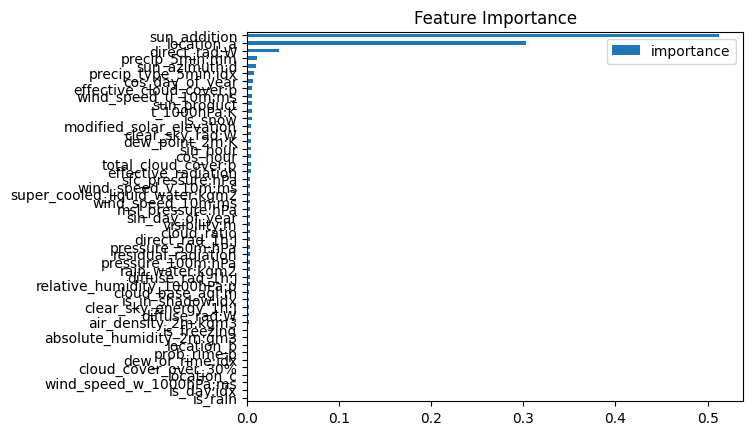

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=["importance"])

plt.figure(figsize=(100,100))
fi.sort_values("importance").plot(kind="barh", title="Feature Importance")
plt.show()

In [ ]:
def multi_predict(x_values :pd.DataFrame, models) -> pd.DataFrame:
    
    results = models[0].predict(x_values)
    for model in models[1:]:
        model: xgb.XGBRegressor
        new_results = model.predict(x_values)
        results += new_results
    

    results = results / len(models)



    return results

        

In [ ]:
results = multi_predict(X_test_estimated_a_processed, reg_models)

In [ ]:
y_pred_val_obs_combined = multi_predict(X_val_obs_combined, reg_models)
y_pred_val_est_combined = multi_predict(X_val_est_combined, reg_models)

# Evaluate the model's performance using Mean Absolute Error (MAE) on the combined validation observed data
mae_obs_combined = mean_absolute_error(y_val_obs_combined, y_pred_val_obs_combined)
mae_est_combined = mean_absolute_error(y_val_est_combined, y_pred_val_est_combined)
print('MAE on validation observed data: ', mae_obs_combined)
print('MAE on validation estimated data: ', mae_est_combined)


MAE on validation observed data:  57.273172307124604
MAE on validation estimated data:  63.51891191477197


In [ ]:
# Predict on the cleaned validation set
from src.features.preprocess_data import get_final_prediction


y_val_pred_est_a = multi_predict(X_test_estimated_a_processed, reg_models)
y_val_pred_est_b = multi_predict(X_test_estimated_b_processed, reg_models)
y_val_pred_est_c = multi_predict(X_test_estimated_c_processed, reg_models)

# Combine the predictions into a single array
y_pred_test_est_combined = get_final_prediction(y_val_pred_est_a, y_val_pred_est_b, y_val_pred_est_c)
y_pred_test_est_combined.shape

from src.models.saving import save_predictions


save_predictions(y_pred_test_est_combined, 'gunnar xgboost both observed and est')


   id  prediction
0   0    1.204643
1   1    1.359870
2   2    1.309225
3   3    1.308232
4   4  211.075043
